## Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [2]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
#matplot inline


## Import the data and Initialization

In [11]:
df = pd.read_excel('obs_data_w.xlsx', sheet_name=0) #sheet_name='Sheet1')
print(df)
type(df)


         V    T  uncertainty             J
0     0.00  100     0.001000  0.000000e+00
1     0.05  100     0.001000  6.417136e-90
2     0.10  100     0.001000  1.081096e-88
3     0.15  100     0.001000  1.719633e-87
4     0.20  100     0.001000  2.725747e-86
5     0.25  100     0.001000  4.319561e-85
6     0.30  100     0.001000  6.845225e-84
7     0.35  100     0.001000  1.084764e-82
8     0.40  100     0.001000  1.719028e-81
9     0.45  100     0.001000  2.724148e-80
10    0.50  100     0.001000  4.316963e-79
11    0.55  100     0.001000  6.841100e-78
12    0.60  100     0.001000  1.084111e-76
13    0.65  100     0.001000  1.717992e-75
14    0.70  100     0.001000  2.722506e-74
15    0.75  100     0.001000  4.314361e-73
16    0.80  100     0.001000  6.836977e-72
17    0.85  100     0.001000  1.083457e-70
18    0.90  100     0.001000  1.716957e-69
19    0.95  100     0.001000  2.720865e-68
20    1.00  100     0.001000  4.311761e-67
21    1.05  100     0.001000  6.832857e-66
22    1.10 

pandas.core.frame.DataFrame

## Train, cross validation and test data
Convert the data frame into series.

### Method 1: Sample function of df

In [4]:
train=df.sample(frac=0.8)  #randaom_state=200
test=df.drop(train.index)
print(train.shape)
print(test.shape)
len(df)

(6315, 4)
(1579, 4)


7894

### Method 2: random array

In [5]:
idx=np.arange(0,len(df))
np.random.shuffle(idx)
temp_split=math.floor(0.8*len(df))
#idx[0:20]
train=df.iloc[idx[0:temp_split],:]
test=df.iloc[idx[temp_split:],:] # Output all the elements after temp_split
print(train.shape)
print(test.shape)

(6315, 4)
(1579, 4)


## Split the data into data and label

In [6]:
train_data=train.loc[:,['V','T']]
train_unc=train.uncertainty
train_J=train.J

test_data=test.loc[:,['V','T']]
test_unc=test.uncertainty
test_J=test.J

# J=J.tolist()

## Add the polynominal features

## Data Normalization ( Two methods, range or stand deviation)  (__We should try both__)

### 1. Range method

__可以减去平均值得到有正负的normalization，到时候试一下怎么弄比较好__

In [7]:
# train data
train_data_norm_r=(train_data-train_data.min(axis=0))/(train_data.max(axis=0)-train_data.min(axis=0))

# test data
test_data_norm_r=(test_data-test_data.min(axis=0))/(test_data.max(axis=0)-test_data.min(axis=0))

# Uncertainity
# train_unc_norm_r=(train_unc-train_unc.min())/(train_unc.max()-train_unc.min())

# Current
# train_J_norm_r=(train_J-train_J.min())/(train_J.max()-train_J.min())



temp=train_data.T
temp_norm=(temp-temp.min(axis=0))/(temp.max(axis=0)-temp.min(axis=0))
print(train_data_norm_r)
print(temp_norm)


             V         T
906   0.973333  0.018333
5622  0.840000  0.126667
7707  0.266667  0.883333
4490  0.826667  0.100000
4898  0.586667  0.110000
2764  0.000000  0.061667
2858  0.280000  0.063333
368   0.853333  0.006667
3805  0.320000  0.085000
4631  0.813333  0.103333
3678  0.546667  0.081667
87    0.146667  0.001667
5856  0.226667  0.133333
1852  0.626667  0.040000
7657  0.000000  0.866667
1793  0.826667  0.038333
6766  0.346667  0.155000
7390  0.120000  0.733333
4578  0.106667  0.103333
2277  0.373333  0.050000
5715  0.213333  0.130000
886   0.706667  0.018333
387   0.093333  0.008333
185   0.440000  0.003333
5590  0.413333  0.126667
3230  0.373333  0.071667
5930  0.280000  0.135000
1052  0.920000  0.021667
2225  0.666667  0.048333
6551  0.240000  0.150000
...        ...       ...
7883  0.160000  1.000000
4965  0.533333  0.111667
4889  0.466667  0.110000
6378  0.693333  0.145000
5082  0.200000  0.115000
4372  0.200000  0.098333
1239  0.413333  0.026667
6570  0.493333  0.150000


### 2. Stand deviation

## Convert Pandas data frame to Numpy array

(6315, 2)
(6315,)


0.15972372006446728

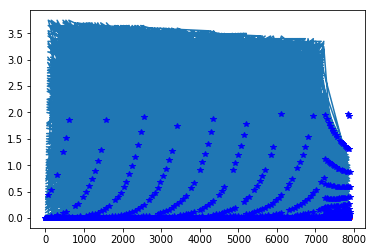

In [12]:
train_data_array=train_data_norm_r.values
train_unc_array=train_unc.values
train_J_array=train_J.values


test_data_array=test_data_norm_r.values
test_unc_array=test_unc.values
test_J_array=test_J.values

print(train_data_array.shape)
print(train_J_array.shape)
plt.plot(train_data.V)
train_unc.plot(style='r.')
train_J.plot(style='b*')

## Create the model

In [9]:
train_data_array.shape[1]

2

In [10]:
def build_model(num_elements):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(train_data_array.shape[1])),
        keras.layers.Dense(num_elements, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    optimizer = tf.train.RMSPropOptimizer(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

n=12
model_unc = build_model(n)
model_unc.summary()
model_J=build_model(n)
model_J.summary()

TypeError: 'int' object is not iterable

## Train the model

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# train the uncertainity
history_unc = model_unc.fit(train_data_array, train_unc_array, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])
# train the currency
history_J=model_J.fit(train_data_array, train_J_array, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])

In [ ]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    y1=np.array(history.history['mean_absolute_error'])
    y2=np.array(history.history['val_mean_absolute_error'])
    plt.plot(history.epoch, y1, label='Train Loss')
    plt.plot(history.epoch, y2, label = 'Val loss')
    plt.legend()
    if y1.max()>y2.max():
        plt.ylim([0, 1.1*y1.max()])
    else:
        plt.ylim([0, 1.1*y2.max()])
            

# plt.subplot(121)
plot_history(history_unc)

# plt.subplot(122)
plot_history(history_J)

In [ ]:
test_predictions = model_J.predict(test_data_array).flatten()

plt.scatter(test_J, test_predictions)
plt.xlabel('True Current Values [A]')
plt.ylabel('Prediction Current Values [A]')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-2, 5], [-2, 5],)
print(test_predictions)